In [70]:
# lstm for time series forecasting
from numpy import sqrt
from numpy import asarray
from pandas import read_csv
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import time
from datetime import datetime
from tensorflow import math
from tensorflow import reduce_mean
import tensorflow as tf
import sys
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [71]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    print('X: \n', X[0:5], '\n Y: \n', y[0:5])
    return asarray(X), asarray(y)

In [72]:
# Need new function to evaluate RMSE based on just 'Percent Output'
# Current state: we have input tensors of shape (None [batch size], 21). Need to find a way to turn that into an "array of losses"
# of shape (None, 21). Then return that.
# Current step: figure out how to index through a tensor. Need to only focus on solar output
def custom_loss(y_actual, y_pred):
    SE_Tensor = math.square(y_pred - y_actual)  #squared difference
    MSE = reduce_mean(SE_Tensor, axis=0)
    #RMSE = tf.math.sqrt(MSE)
    
    Zeros = tf.zeros_like(MSE) #create tensor of zeros
    Mask = [False, False, False, False, False, False, False, False, False, False,
            False, False, False, False, False, False, True] #create mask
    Solar_MSE = tf.where(Mask, MSE, Zeros) #create tensor where every loss is 0 except solar output
    
    #print_output = tf.print(Solar_MSE, "Solar_MSE: ")
    
    return Solar_MSE

In [73]:
# Need to make a custom evaluation metric as well as loss function
# RMSE should be between 0 and 1. Giving RMSEs of 20+ and not dropping below 1. Something is wrong here.
def custom_eval(y_actual, y_pred):
    SE_Tensor = math.square(y_pred - y_actual)  #squared difference
    MSE = reduce_mean(SE_Tensor, axis=0)
    
    Zeros = tf.zeros_like(MSE) #create tensor of zeros
    Mask = [False, False, False, False, False, False, False, False, False, False,
            False, False, False, False, False, False, True] #create mask
    Solar_MSE = tf.where(Mask, MSE, Zeros) #create tensor where every loss is 0 except solar output
    
    Solar_RMSE = tf.math.sqrt(Solar_MSE)
    
    #print_output = tf.print(Solar_RMSE, "Solar_RMSE: ")
    
    return Solar_RMSE

In [74]:
# load the dataset
df = read_csv("Normalized Aggregated 2018 Compiled Weather Data.csv", index_col=0)

In [75]:
df.shape

(7789, 17)

In [76]:
"""
# Create holdout set
PREDICTION_SET_SIZE = 580
N_STEPS = 5

df_holdout = df.iloc[-PREDICTION_SET_SIZE:]
df = df.iloc[:-PREDICTION_SET_SIZE]

holdout_X, holdout_y = split_sequence(df_holdout.values.astype('float32'), N_STEPS)
"""

"\n# Create holdout set\nPREDICTION_SET_SIZE = 580\nN_STEPS = 5\n\ndf_holdout = df.iloc[-PREDICTION_SET_SIZE:]\ndf = df.iloc[:-PREDICTION_SET_SIZE]\n\nholdout_X, holdout_y = split_sequence(df_holdout.values.astype('float32'), N_STEPS)\n"

In [77]:
# retrieve the values
values = df.values.astype('float32')
# specify the window size
n_steps = 5
# split into samples
X, y = split_sequence(values, n_steps)
# reshape into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 17)) #change if df shape changes
# split into train/test
n_test = 1000
X_train, X_test, y_train, y_test = X[:-n_test], X[-n_test:], y[:-n_test], y[-n_test:]

X: 
 [array([[-8.7754160e-01, -8.0549186e-01, -7.3295528e-01,  4.4067781e-02,
        -9.7365022e-02, -1.3651767e+00,  1.3402462e+00,  1.3835880e+00,
         1.2506769e+00,  1.5370469e-01, -3.8461256e-01, -4.2205310e-01,
        -2.2704291e-01,  1.3451765e+00,  5.9509468e-01,  6.5150124e-01,
         1.8092882e-02],
       [-9.3132329e-01, -8.5371113e-01, -6.7656237e-01,  2.6915717e-01,
        -9.7365022e-02, -9.5923126e-01,  1.6563585e+00,  1.3684469e+00,
         1.2506769e+00,  3.7587231e-01, -5.6177258e-01, -5.3642035e-01,
        -6.3517523e-01,  1.3451765e+00,  5.9509468e-01,  7.9604214e-01,
        -3.0698301e-03],
       [-1.0388865e+00, -9.5014971e-01, -6.0137177e-01,  6.6306359e-01,
        -9.7365022e-02, -1.3651767e+00,  1.3030566e+00,  1.5047158e+00,
         1.2506769e+00,  1.5370469e-01, -4.5053256e-01, -4.2205310e-01,
        -6.3517523e-01,  1.3451765e+00,  5.9509468e-01,  9.4058311e-01,
        -1.2706623e-03],
       [-1.0448624e+00, -9.5550740e-01, -5.2618122e-01,

In [78]:
# define model
# improvement area : try adding dropout
model = Sequential()
model.add(LSTM(100, activation='relu', kernel_initializer='he_normal', input_shape=(n_steps,17))) #Change if df shape changes
model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1))
# compile the model
model.compile(optimizer='adam', loss=custom_loss, metrics=[custom_eval])
#model.compile(optimizer='adam', loss='mse', metrics=[custom_eval])

In [79]:
# fit the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2, validation_data=(X_test, y_test))
# evaluate the model
mse, mae = model.evaluate(X_test, y_test, verbose=0)
print('MSE: %.3f, RMSE: %.3f, MAE: %.3f' % (mse, sqrt(mse), mae))

Epoch 1/100
212/212 - 2s - loss: 0.0058 - custom_eval: 0.0151 - val_loss: 0.0034 - val_custom_eval: 0.0132 - 2s/epoch - 11ms/step
Epoch 2/100
212/212 - 1s - loss: 0.0012 - custom_eval: 0.0078 - val_loss: 0.0033 - val_custom_eval: 0.0122 - 726ms/epoch - 3ms/step
Epoch 3/100
212/212 - 1s - loss: 7.3040e-04 - custom_eval: 0.0063 - val_loss: 0.0016 - val_custom_eval: 0.0094 - 727ms/epoch - 3ms/step
Epoch 4/100
212/212 - 1s - loss: 4.8669e-04 - custom_eval: 0.0052 - val_loss: 0.0013 - val_custom_eval: 0.0086 - 721ms/epoch - 3ms/step
Epoch 5/100
212/212 - 1s - loss: 3.7035e-04 - custom_eval: 0.0046 - val_loss: 0.0012 - val_custom_eval: 0.0082 - 732ms/epoch - 3ms/step
Epoch 6/100
212/212 - 1s - loss: 3.2410e-04 - custom_eval: 0.0043 - val_loss: 0.0012 - val_custom_eval: 0.0082 - 756ms/epoch - 4ms/step
Epoch 7/100
212/212 - 1s - loss: 2.8638e-04 - custom_eval: 0.0040 - val_loss: 0.0013 - val_custom_eval: 0.0087 - 741ms/epoch - 3ms/step
Epoch 8/100
212/212 - 1s - loss: 2.8474e-04 - custom_eval:

Epoch 60/100
212/212 - 1s - loss: 4.3780e-05 - custom_eval: 0.0016 - val_loss: 5.2316e-04 - val_custom_eval: 0.0054 - 927ms/epoch - 4ms/step
Epoch 61/100
212/212 - 1s - loss: 4.5220e-05 - custom_eval: 0.0016 - val_loss: 5.3068e-04 - val_custom_eval: 0.0054 - 967ms/epoch - 5ms/step
Epoch 62/100
212/212 - 1s - loss: 4.5662e-05 - custom_eval: 0.0016 - val_loss: 5.6866e-04 - val_custom_eval: 0.0056 - 920ms/epoch - 4ms/step
Epoch 63/100
212/212 - 1s - loss: 4.6127e-05 - custom_eval: 0.0016 - val_loss: 5.5376e-04 - val_custom_eval: 0.0055 - 918ms/epoch - 4ms/step
Epoch 64/100
212/212 - 1s - loss: 4.5708e-05 - custom_eval: 0.0016 - val_loss: 6.1424e-04 - val_custom_eval: 0.0058 - 1s/epoch - 5ms/step
Epoch 65/100
212/212 - 1s - loss: 4.5262e-05 - custom_eval: 0.0016 - val_loss: 5.5696e-04 - val_custom_eval: 0.0055 - 1s/epoch - 5ms/step
Epoch 66/100
212/212 - 1s - loss: 4.5691e-05 - custom_eval: 0.0016 - val_loss: 5.7619e-04 - val_custom_eval: 0.0056 - 1s/epoch - 5ms/step
Epoch 67/100
212/212 -

32/32 [==============================] - 0s 3ms/step
[[-2.44079717e-03]
 [-5.20871766e-03]
 [-4.77314182e-03]
 [-6.31723739e-03]
 [-5.60125150e-03]
 [-3.14011984e-03]
 [-5.56124188e-03]
 [ 3.06296162e-03]
 [-3.53403576e-03]
 [ 2.05707662e-02]
 [ 9.38868821e-02]
 [ 8.74989703e-02]
 [ 6.78467378e-02]
 [ 5.32302633e-02]
 [ 5.22687212e-02]
 [ 6.48161769e-02]
 [ 1.77183211e-01]
 [ 1.04207538e-01]
 [ 4.90516797e-02]
 [ 1.38066206e-02]
 [ 1.18299387e-03]
 [-4.07780521e-03]
 [-3.74385901e-03]
 [-2.42012553e-03]
 [-3.89632396e-03]
 [-5.28240018e-03]
 [-2.68240459e-03]
 [-3.16127576e-03]
 [-1.33682042e-05]
 [-2.23855488e-03]
 [-1.60280056e-03]
 [ 3.57114524e-03]
 [ 6.30130246e-03]
 [ 1.28574930e-02]
 [ 4.26984057e-02]
 [ 4.94766384e-02]
 [ 2.02055573e-01]
 [ 1.58266902e-01]
 [ 1.53295115e-01]
 [ 5.37513345e-02]
 [ 3.37486453e-02]
 [ 9.34611075e-03]
 [-5.12982346e-03]
 [ 6.91520236e-03]
 [-1.05497707e-02]
 [ 2.78959051e-04]
 [ 2.10962258e-03]
 [-2.27155723e-03]
 [-9.20150243e-03]
 [-4.02593799e-0

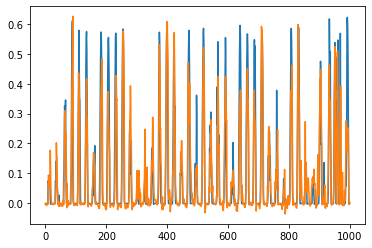

In [80]:
# Make prediction using holdout set
yhat = model.predict(X_test)
print(yhat)
figure, axis = plt.subplots(1, 1)
axis.plot([i for i in range(len(y_test))], y_test[:, -1])
axis.plot([i for i in range(len(yhat))], yhat)
plt.show()
#plt.savefig("Solar Forecasting/matplotlib.png")

In [81]:
#holdyDF = pd.DataFrame(holdout_y)
#holdyDF.head()

#print(holdout_y[:,-1])
rehat = np.reshape(yhat, (1, n_test))

difference = rehat - y_test[:,-1]
sq_difference = np.square(difference)
sum_sq = np.sum(sq_difference)
MSE = sum_sq/n_test
print(MSE)

#rehat = np.reshape(yhat, (1, 575))
#print(rehat)

0.00667027235031128


In [82]:
print(holdout_X.shape)

(575, 5, 17)
